In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "09_deploying/09a_inmemory.ipynb"
_nb_title = "Predictions on in-memory model"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Predictions on in-memory model&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F09_deploying%2F09a_inmemory.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F09_deploying%2F09a_inmemory.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/09_deploying/09a_inmemory.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/09_deploying/09a_inmemory.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/09_deploying/09a_inmemory.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Predictions on in-memory model.

In this notebook, we start from an already trained and saved model (as in Chapter 7).
For convenience, we have put this model in a public bucket in gs://practical-ml-vision-book/flowers_5_trained

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Exported model

We start from a trained and saved model from Chapter 7.
<pre>
  model.save(...)
</pre>

In [1]:
MODEL_LOCATION='gs://practical-ml-vision-book/flowers_5_trained'

In [2]:
!gsutil ls {MODEL_LOCATION}

gs://practical-ml-vision-book/flowers_5_trained/saved_model.pb
gs://practical-ml-vision-book/flowers_5_trained/variables/


In [3]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {MODEL_LOCATION}

The given SavedModel SignatureDef contains the following input(s):
  inputs['filenames'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_filenames:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['flower_type_int'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['flower_type_str'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall:1
  outputs['probability'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall:2
Method name is: tensorflow/serving/predict


## In-memory model (Python program)

In [13]:
import tensorflow as tf
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['serving_default']
filenames = [
    'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)
print('******')
print(pred['flower_type_str'].numpy())

{'probability': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.61915255, 0.9999844 , 0.995083  , 0.97518593, 0.954918  ],
      dtype=float32)>, 'flower_type_str': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'daisy', b'tulips', b'tulips'],
      dtype=object)>, 'flower_type_int': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 0, 4, 4])>}
******
[b'dandelion' b'dandelion' b'daisy' b'tulips' b'tulips']


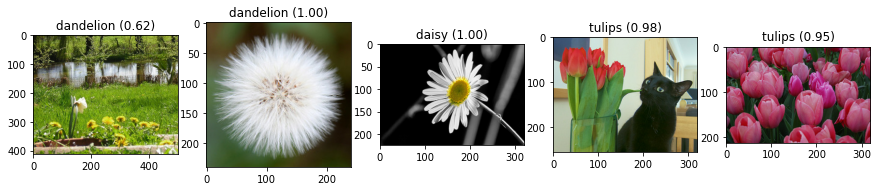

In [14]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (filename, prob, pred_label) in enumerate(
        zip(filenames, pred['probability'].numpy(), pred['flower_type_str'].numpy())):
    
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    ax[idx].imshow((img.numpy()));
    
    ax[idx].set_title('{} ({:.2f})'.format(pred_label.decode('utf-8'), prob))    

## In memory model (Beam pipeline)

Make sure to share the model so that it is not loaded for each element.
There will be a different model on different worker machines.

In [39]:
import apache_beam as beam
from apache_beam.utils.shared import Shared
import tensorflow as tf

class ModelPredict:
    def __init__(self, shared_handle, model_location):
        self._shared_handle = shared_handle
        self._model_location = model_location 

    def __call__(self, filenames):
        def initialize_model():
            print('Loading Keras model from ' + self._model_location)
            return (tf.keras.models.load_model(self._model_location)
                    .signatures['serving_default'])
        
        serving_fn = self._shared_handle.acquire(initialize_model)
        if isinstance(filenames, str):
            # only one element, put it into a batch of 1
            result = serving_fn(tf.convert_to_tensor([filenames]))
        else:
            # a list
            result = serving_fn(tf.convert_to_tensor(filenames))
        return {
            'filenames': filenames,
            'probability': result['probability'].numpy(),
            'pred_label': result['flower_type_str'].numpy()
        }

with beam.Pipeline() as p:
    
    shared_handle = Shared()
    
    (p 
     | 'input' >> beam.Create([
        'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
        'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
        'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
     ]) 
     | 'pred' >> beam.Map(ModelPredict(shared_handle, MODEL_LOCATION))
     | 'write' >> beam.io.textio.WriteToText('/tmp/out.txt', num_shards=1)
    )

!cat /tmp/out.txt*

Loading Keras model from gs://practical-ml-vision-book/flowers_5_trained


{'filenames': 'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg', 'probability': array([0.61915237], dtype=float32), 'pred_label': array([b'dandelion'], dtype=object)}
{'filenames': 'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg', 'probability': array([0.9999844], dtype=float32), 'pred_label': array([b'dandelion'], dtype=object)}
{'filenames': 'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg', 'probability': array([0.995083], dtype=float32), 'pred_label': array([b'daisy'], dtype=object)}
{'filenames': 'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg', 'probability': array([0.97518593], dtype=float32), 'pred_label': array([b'tulips'], dtype=object)}
{'filenames': 'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg', 'probability': array([0.954918], dtype=float32), 'pred_label': array([b'tulips'], dtype=object)}


If we pass in a list of filenames, the entire list is sent to the model.
This is useful if we do a GroupBy for example

For efficiency, it can be helpful to generate a random key, group by it.

In [40]:
with beam.Pipeline() as p:
    
    shared_handle = Shared()
    
    (p 
     | 'input' >> beam.Create([
        'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
        'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
        'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
     ]) 
     | 'addlabel' >> beam.Map(lambda filename: (filename.split('/')[5], filename))
     | 'groupbykey' >> beam.GroupByKey()  # (daisy, [daisyfiles])
     | 'addpred' >> beam.Map(lambda x: ModelPredict(shared_handle, MODEL_LOCATION)(x[1]))
     | 'write' >> beam.io.textio.WriteToText('/tmp/out.txt', num_shards=1)
    )

!cat /tmp/out.txt*

Loading Keras model from gs://practical-ml-vision-book/flowers_5_trained


{'filenames': ['gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg'], 'probability': array([0.61915237, 0.9999844 ], dtype=float32), 'pred_label': array([b'dandelion', b'dandelion'], dtype=object)}
{'filenames': ['gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg'], 'probability': array([0.995083], dtype=float32), 'pred_label': array([b'daisy'], dtype=object)}
{'filenames': ['gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg', 'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'], 'probability': array([0.97518593, 0.954918  ], dtype=float32), 'pred_label': array([b'tulips', b'tulips'], dtype=object)}


In [65]:
with beam.Pipeline() as p:
    
    shared_handle = Shared()
    
    (p 
     | 'input' >> beam.Create([
        'gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg',
        'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
        'gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
        'gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
     ]) 
     | 'batch' >> beam.BatchElements(min_batch_size=2, max_batch_size=3)
     | 'addpred' >> beam.Map( ModelPredict(shared_handle, MODEL_LOCATION) )
     | 'write' >> beam.Map(print)
    )

Loading Keras model from gs://practical-ml-vision-book/flowers_5_trained
{'filenames': ['gs://cloud-ml-data/img/flower_photos/dandelion/9818247_e2eac18894.jpg', 'gs://cloud-ml-data/img/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg'], 'probability': array([0.61915237, 0.9999844 ], dtype=float32), 'pred_label': array([b'dandelion', b'dandelion'], dtype=object)}
{'filenames': ['gs://cloud-ml-data/img/flower_photos/daisy/9299302012_958c70564c_n.jpg', 'gs://cloud-ml-data/img/flower_photos/tulips/8733586143_3139db6e9e_n.jpg'], 'probability': array([0.995083  , 0.97518593], dtype=float32), 'pred_label': array([b'daisy', b'tulips'], dtype=object)}
{'filenames': ['gs://cloud-ml-data/img/flower_photos/tulips/8713397358_0505cc0176_n.jpg'], 'probability': array([0.954918], dtype=float32), 'pred_label': array([b'tulips'], dtype=object)}


## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.